### Librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import explained_variance_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold # cross validation
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit # cross validation 
from sklearn.metrics import auc
import itertools
from sklearn.feature_selection import RFE

# models
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### Se carga el dataset de kendra y se borran las filas duplicadas

In [2]:
df = pd.read_csv("dataset-kendra.csv", delimiter=',')

In [3]:
print(df.duplicated().sum())
df = df.drop_duplicates()

499


In [4]:
df

,SinkClassification,CommandLine,EnvironmentVariable,File,Network,NumberOfElementsCopiedWithinBounds,ArrayWriteIndexWithinBounds,FormatStringPrecisionWithinBounds,StringCopyWithinBounds,IsCharacterCaseConversionSink,Vulnerable?
0,7,0,0,0,0,-1,0,-1,-1,-1,0
2,7,0,0,0,0,-1,1,-1,-1,-1,1
8,1,0,0,0,0,0,-1,-1,-1,-1,0
70,1,0,0,0,0,-1,-1,-1,0,-1,0
245,1,0,0,0,0,1,-1,-1,-1,-1,1
342,1,0,0,0,0,-1,-1,-1,1,-1,1


In [5]:
y_kendra = df['Vulnerable?'].values
X_kendra = df.drop(columns=['EnvironmentVariable','File', 'Network','Vulnerable?'], axis=1)
X_kendra = X_kendra.values

### Se carga el dataset de prueba y se borran las filas duplicadas

In [6]:
df = pd.read_csv("dataset-propio.csv", delimiter=',')
print(df.duplicated().sum())
df = df.drop_duplicates()
df

17


,SinkClassification,CommandLine,EnvironmentVariable,File,Network,NumberOfElementsCopiedWithinBounds,ArrayWriteIndexWithinBounds,FormatStringPrecisionWithinBounds,StringCopyWithinBounds,IsCharacterCaseConversionSink,Vulnerable?
0,1,0,0,0,0,-1,-1,-1,1,-1,1
1,4,0,0,0,0,-1,-1,1,-1,-1,1
4,7,0,0,0,0,-1,1,-1,-1,-1,1
5,5,3,0,0,0,-1,-1,-1,-1,-1,0
6,1,0,0,0,0,0,-1,-1,-1,-1,0
8,7,0,0,0,0,-1,0,-1,-1,-1,0
10,4,0,0,0,0,-1,-1,0,-1,-1,0
13,6,1,0,0,0,-1,-1,0,-1,-1,0
14,1,0,0,0,0,-1,-1,-1,0,-1,0
15,1,0,0,0,0,1,-1,-1,-1,-1,1


In [7]:
y = df['Vulnerable?'].values
# estas caracteristicas no son relevantes dado que no se utilizan
X = df.drop(columns=['EnvironmentVariable','File', 'Network','Vulnerable?'], axis=1)
X = X.values

### Se definen los modelos de ML a utilizar

In [10]:
gnb = GaussianNB()
dt = DecisionTreeClassifier(criterion='entropy')
lr = LogisticRegression(solver='liblinear')
svc = SVC(random_state=0, tol=1e-2, probability=True, gamma='auto')

### Se entrenan los modelos

In [11]:
gnb.fit(X,y)
dt.fit(X,y)
lr.fit(X,y)
svc.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.01,
  verbose=False)

### Se predicen los modelos con los  datos de test sin etiquetar

In [12]:
y_predict_gnb = gnb.predict(X_kendra)
y_predict_dt = dt.predict(X_kendra)
y_predict_lr = lr.predict(X_kendra)
y_predict_svc = svc.predict(X_kendra)

### Accuracy Score

In [13]:
print('Accuracy Naive Bayes: %.2f' % accuracy_score(y_kendra, y_predict_gnb))
print('Accuracy Decision Tree: %.2f' % accuracy_score(y_kendra, y_predict_dt))
print('Accuracy Logistic Regression: %.2f' % accuracy_score(y_kendra, y_predict_lr))
print('Accuracy Support Vector Classification: %.2f' % accuracy_score(y_kendra, y_predict_svc))

Accuracy Naive Bayes: 0.50
Accuracy Decision Tree: 1.00
Accuracy Logistic Regression: 0.50
Accuracy Support Vector Classification: 0.83


### Plot de curvas de aprendizaje del Árbol de Decisión

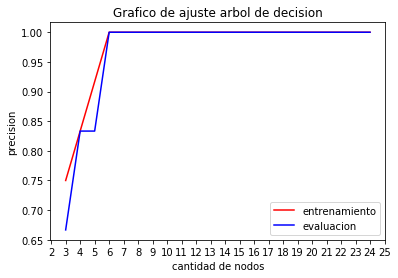

In [14]:
#Grafico de ajuste del árbol de decisión
train_prec =  []
eval_prec = []
max_deep_list = list(range(3, 25))
for deep in max_deep_list:
    arbol3 = DecisionTreeClassifier(criterion='entropy', max_depth=deep)
    arbol3.fit(X, y)
    train_prec.append(arbol3.score(X, y))
    eval_prec.append(arbol3.score(X_kendra, y_kendra))
plt.locator_params(axis='x', nbins=25)
plt.plot(max_deep_list, train_prec, color='r', label='entrenamiento')
plt.plot(max_deep_list, eval_prec, color='b', label='evaluacion')
plt.title('Grafico de ajuste arbol de decision')
plt.legend()
plt.ylabel('precision')
plt.xlabel('cantidad de nodos')
plt.show()

### Matriz de confusión

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()
    plt.show()

In [16]:
class_names=[0,1]

Confusion matrix, without normalization


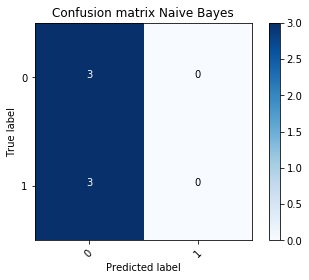

In [17]:
# Matriz de confusión del Naive Bayes 
gnb_matrix=confusion_matrix(y_kendra, y_predict_gnb, labels=class_names)
plot_confusion_matrix(gnb_matrix, classes=class_names, title='Confusion matrix Naive Bayes')

Confusion matrix, without normalization


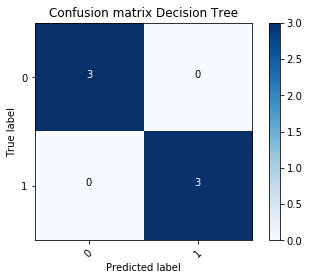

In [18]:
# Matriz de confusión del Decision Tree
dt_matrix=confusion_matrix(y_kendra, y_predict_dt, labels=class_names)
plot_confusion_matrix(dt_matrix, classes=class_names, title='Confusion matrix Decision Tree')

Confusion matrix, without normalization


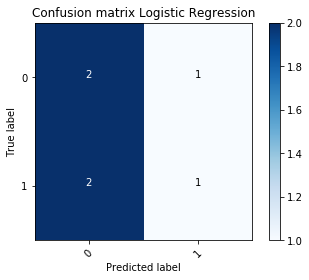

In [19]:
# Matriz de confusión del Logistic Regression
lr_matrix=confusion_matrix(y_kendra, y_predict_lr, labels=class_names)
plot_confusion_matrix(lr_matrix, classes=class_names, title='Confusion matrix Logistic Regression')

Confusion matrix, without normalization


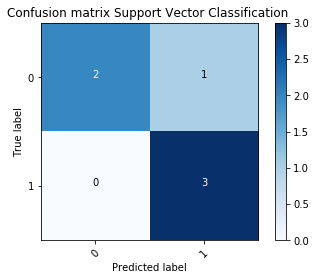

In [20]:
# Matriz de confusión del Support Vector Classification 
svc_matrix=confusion_matrix(y_kendra, y_predict_svc, labels=class_names)
plot_confusion_matrix(svc_matrix, classes=class_names, title='Confusion matrix Support Vector Classification ')